In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import seaborn as sns
cm = sns.color_palette(as_cmap=True)

## Simulation notes
For the simulation, the time is following this convention:
10 time unit = 1 ms


In [4]:
def epileptor(q, parameters):

	x1,y1,z,x2,y2,g = q
	a1, b1, c1, d1, tau, a2, c2, m, x0, r, s, Irest1, Irest2, Is1, Is2 =\
    parameters['a1'], parameters['b1'], parameters['c1'], parameters['d1'], parameters['tau'], \
    parameters['a2'], parameters['c2'], parameters['m'], parameters['x0'], parameters['r'], \
    parameters['s'], parameters['Irest1'], parameters['Irest2'], parameters['Is1'], parameters['Is2']
    
    ###################  Population 1 #################
	if x1 < 0:
		dx1 = y1  - a1 * (x1)**3  + b1 * (x1)**2 - z + Irest1 + Is1
	else:
		dx1 = y1 + (m -x2 + 0.6 * (z-4)**2)*x1- z + Irest1 + Is1
	dy1 = c1 - d1 * (x1)**2 - y1

	################## Population 2 ################### 
	dx2 = -y2 + x2 - (x2)**3 + Irest2 + 2*g - c2*(z-3.5) + Is2
	if x2 < -0.25:
		dy2 = 1./tau * (-y2)
	else:
		dy2 = 1./tau * (-y2 + a2 * (x2 + 0.25 ))
	dg = -0.01 * (g - 0.1*x1);

	################### Energy #####################"
	dz = r* (s * (x1 - x0) - z)
	#pdb.set_trace()
	return np.hstack((dx1, dy1, dz, dx2, dy2, dg))

# Parameters
parameters = {'a1':1, 'b1':3, 'c1':1, 'd1':5,
              'tau':10, 'a2':6, 'c2':0.3, 'm':0,
              'x0':-2.25, 'r':0.00005, 's':4,
              'Irest1':3.1, 'Irest2':0.45, 'Is1':0, 'Is2':0}

# sim parameters
dt = 0.001
t_sim_init = 100
n_samples_init = int(t_sim_init/dt)
t_sim = 4000
n_samples = int(t_sim/dt)
upsamp = 1
t = np.linspace(0, t_sim, t_sim*upsamp)
   
# stim parameters
t_start = 100
Is1 = 2
Is2 = 5
I_duration = .3
pulse_per_step = 0.2
size_block = 25 # Size block that composed stimulation, ex: 1s stim = 4x 0.25s blocks

lllq, llte, llstim = [], [], []
for irep in range(10):
    list_train = np.array([0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 6, 7, 8, 10, 12, 15, 20, 25, 30])*100 # Train Stim duration
    llq, lte, lstim = [], [], []
    for length_stim in list_train:
        print(length_stim)
        stim = 1

        n_block = round(length_stim / size_block)
        stim_per_block = round(pulse_per_step * size_block)
        timestamp_stim = np.full(n_block * 5, np.nan) # 5 because 5 stim per block
        for i in range(n_block):
            timestamp_stim[i * stim_per_block : i * stim_per_block + stim_per_block] = np.sort(np.random.rand(stim_per_block) * size_block + (i * size_block)) # Randomly selected IPI for this block

        # Fin initial conditions by root solving
        q0 = [-1.37, -8.39,  2.92, -0.71,  0.  , -0.14]
        q = fsolve(epileptor, q0, args=parameters)

        for it in range(n_samples_init):
            # Runge-Kutta scheme
            p1 = epileptor(q, parameters)
            p2 = epileptor(q+(dt/2)*p1, parameters)
            p3 = epileptor(q+(dt/2)*p2, parameters)
            p4 = epileptor(q+(dt/2)*p3, parameters)
            q += dt/6 * (p1+2*p2+2*p3+p4)


        lq = []
        for it in range(n_samples):
            # if it%10000==0:
            #     print(it)
            tc = it*dt
            if q[0]>-.5 and stim:
                stim = 0 # no stim after a seizure
                lte.append(tc)
            elif stim==1 and it==n_samples-1:
                lte.append(t_sim)

            tstim = 0
            if stim:
                for it_stim in timestamp_stim:
                    if tc>=it_stim and tc<it_stim + I_duration:
                        tstim = 1
            if tstim:
                parameters['Is1'] = Is1
                parameters['Is2'] = Is2
            else:
                parameters['Is1'] = 0
                parameters['Is2'] = 0

            # Runge-Kutta scheme
            p1 = epileptor(q, parameters)
            p2 = epileptor(q+(dt/2)*p1, parameters)
            p3 = epileptor(q+(dt/2)*p2, parameters)
            p4 = epileptor(q+(dt/2)*p3, parameters)
            q += dt/6 * (p1+2*p2+2*p3+p4)

            if it%int(1/(upsamp*dt))==0:
                lq.append(q.copy())
        llq.append(lq)
        lstim.append(timestamp_stim)
    llte.append(lte)
    lllq.append(llq)
    llstim.append(lstim)
lllq = np.array(lllq)
llte = np.array(llte)
llstim = np.array(llstim)

25.0
50.0
75.0
100.0
150.0
200.0
250.0
300.0
350.0
400.0
500.0
600.0
700.0
800.0
1000.0
1200.0
1500.0
2000.0
2500.0
3000.0
25.0
50.0
75.0
100.0
150.0
200.0
250.0
300.0
350.0
400.0
500.0
600.0
700.0
800.0
1000.0
1200.0
1500.0
2000.0
2500.0
3000.0
25.0
50.0
75.0
100.0
150.0
200.0
250.0
300.0
350.0
400.0
500.0
600.0
700.0
800.0
1000.0
1200.0
1500.0
2000.0
2500.0
3000.0
25.0
50.0
75.0
100.0
150.0
200.0
250.0
300.0
350.0
400.0
500.0
600.0
700.0
800.0
1000.0
1200.0
1500.0
2000.0
2500.0
3000.0
25.0
50.0
75.0
100.0
150.0
200.0
250.0
300.0
350.0
400.0
500.0
600.0
700.0
800.0
1000.0
1200.0
1500.0
2000.0
2500.0
3000.0
25.0
50.0
75.0
100.0
150.0
200.0
250.0
300.0
350.0
400.0
500.0
600.0
700.0
800.0
1000.0
1200.0
1500.0
2000.0
2500.0
3000.0
25.0
50.0
75.0
100.0
150.0
200.0
250.0
300.0
350.0
400.0
500.0
600.0
700.0
800.0
1000.0
1200.0
1500.0
2000.0
2500.0
3000.0
25.0
50.0
75.0
100.0
150.0
200.0
250.0
300.0
350.0
400.0
500.0
600.0
700.0
800.0
1000.0
1200.0
1500.0
2000.0
2500.0
3000.0
25.0
50.0
75.0
1

<ipython-input-4-db52b678f45c>:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  llstim = np.array(llstim)


In [5]:
lllq = np.array(lllq)
lllq.shape

(10, 20, 4000, 6)

### Time series

0
0.024407476718119075
0.15328115959068583
0.15753904553898837
0.20014012491422506
0.24222029119972252
1
0.0680373699054346
0.11210354633949207
0.1437017947641658
0.15797595003825324
0.20266397981577783
0.28403246391533415
0.29997929741531854
0.36537036768962977
0.4329546795077624
0.49043616483914376
2
0.011822328417204986
0.02148234487312703
0.09325024021595313
0.14462100265958805
0.1922438695594234
0.30206854184467513
0.3200380962506366
0.332464653230337
0.4388022570474266
0.469778047859527
0.5334512237811935
0.5672270082797558
0.6397056259516425
0.6869230604627796
0.7258642893430727


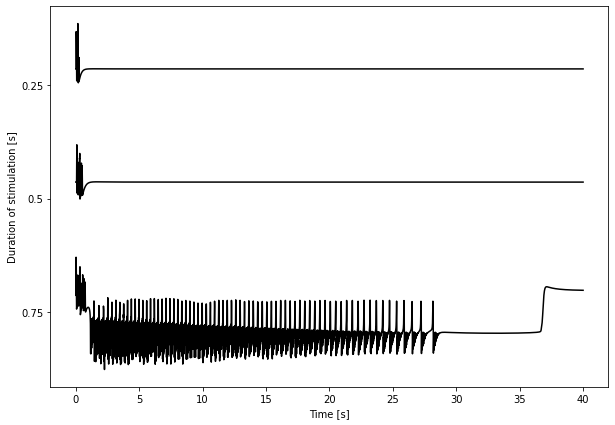

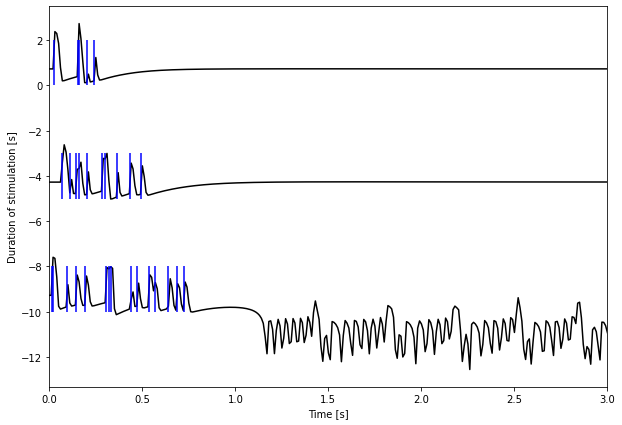

In [26]:
ts = -lllq[:, :, :, 0] + lllq[:, :, :, 3]
plt.figure(figsize=(10, 7))
for irep in range(1):
    for in_stim, n_stim in enumerate(list_train[:3]):
        # time in seconds]
        plt.plot(t/100, ts[irep, in_stim] - 5*in_stim, 'k')
    # plt.xlim([0,2])
    plt.yticks(np.arange(0, -5*len(list_train[:3]), -5), list_train[:3]/100)
    plt.xlabel('Time [s]')
    plt.ylabel('Duration of stimulation [s]')
plt.savefig('figures/supp_arrhythmic.svg')

plt.figure(figsize=(10, 7))
intervals_draw = [[0, 2], [-5, -3], [-10, -8]]
for irep in range(1):
    for in_stim, n_stim in enumerate(list_train[:3]):
        # time in seconds]
        plt.plot(t/100, ts[irep, in_stim] - 5*in_stim, 'k')
        for stim in llstim[0][in_stim]:
            print(stim/100)
            plt.vlines(stim/100, intervals_draw[in_stim][0], intervals_draw[in_stim][1], 'b')
    # plt.xlim([0,2])
    # plt.yticks(np.arange(0, -5*len(list_train[:3]), -5), list_train[:3]/100)
    plt.xlabel('Time [s]')
    plt.xlim([0, 3])
    plt.ylabel('Duration of stimulation [s]')
plt.savefig('figures/supp_arrhythmic_zoomed.svg')

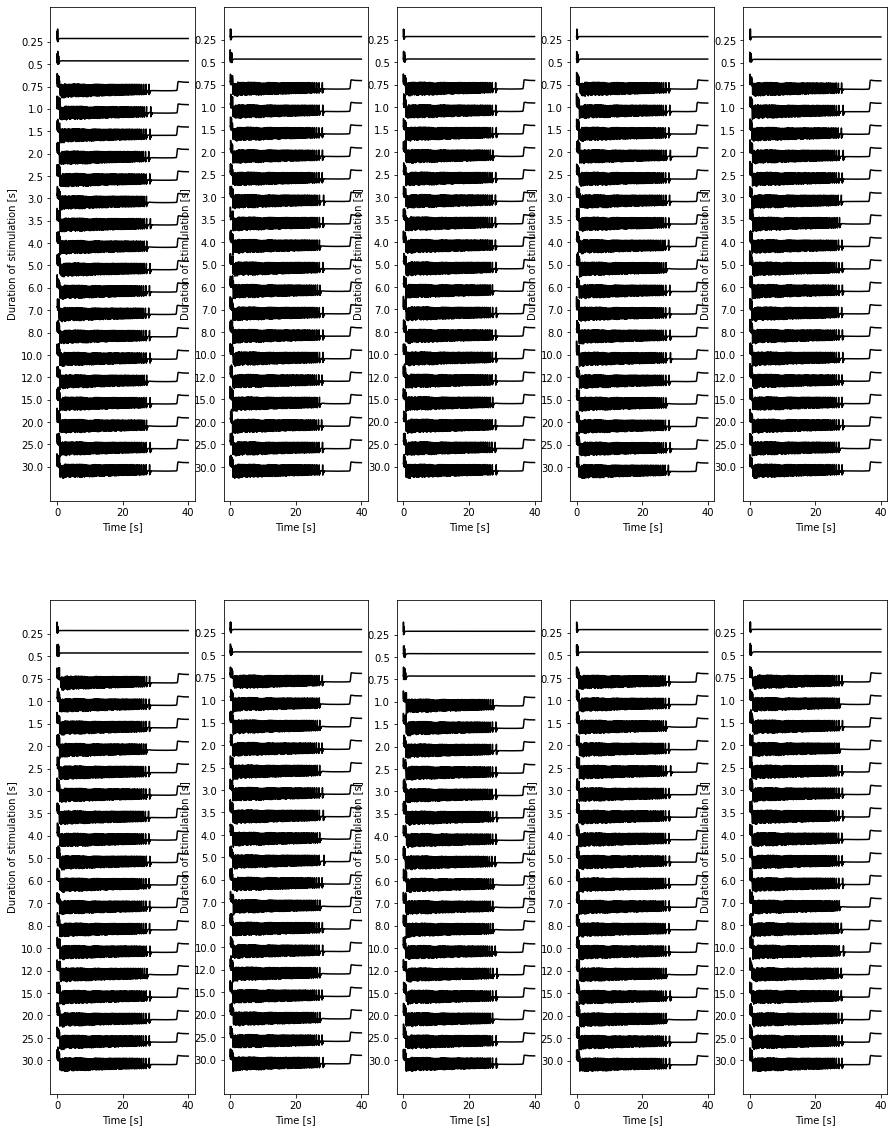

In [14]:
ts = -lllq[:, :, :, 0] + lllq[:, :, :, 3]
plt.figure(figsize=(15, 20))
for irep in range(10):
    plt.subplot(2, 5, irep+1)
    for in_stim, n_stim in enumerate(list_train):
        # time in seconds
        plt.plot(t/100, ts[irep, in_stim] - 5*in_stim, 'k')
    # plt.xlim([0,2])
    plt.yticks(np.arange(0, -5*len(list_train), -5), list_train/100)
    plt.xlabel('Time [s]')
    plt.ylabel('Duration of stimulation [s]')
plt.savefig('figures/train_stim_time_series_arrhythmic.svg')